In [2]:
import numpy as np
from pymatching import Matching
import matplotlib.pyplot as plt
from scipy import sparse, linalg
import CompassCodes as cc
import stim 
import pandas as pd
from compass_code_correlated_error import depolarizing_err


In [26]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    # after_clifford_depolarization=0.001,
    # after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.05)
    # before_round_data_depolarization=0.001)

In [27]:
print(repr(surface_code_circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8

In [5]:
sc_no_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [6]:
sc_err =stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

<pymatching.Matching object with 8 detectors, 0 boundary nodes, and 11 edges>


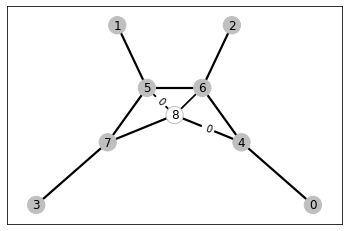

In [7]:
matching_from_c = Matching.from_stim_circuit(sc_err)
matching_from_c.draw()
print(matching_from_c)

In [9]:
d = 3
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

In [10]:
def convert_sparse_to_d(sparse_mat):
    rows, cols, values = sparse.find(sparse_mat)
    d = {}

    for i in range(len(rows)):
        plaq = rows[i]
        qubit = cols[i]

        if plaq not in d:
            d[plaq] = [cols[i]]
        else:
            d[plaq] += [cols[i]]
    sorted_d = dict(sorted(zip(d.keys(),d.values())))
    return sorted_d

d_z = convert_sparse_to_d(H_z)
print(d_z)

d_x = convert_sparse_to_d(H_x)
print(d_x)

{0: [0, 3], 1: [1, 2, 4, 5], 2: [3, 4, 6, 7], 3: [5, 8]}
{0: [0, 1, 3, 4], 1: [6, 7], 2: [1, 2], 3: [4, 5, 7, 8]}


In [11]:
def qubit_to_plaq_d(H):
    rows, cols, values = sparse.find(H)
    d = {}
    for i in range(len(cols)):
        q = cols[i]
        plaq = rows[i]

        if q not in d:
            d[q] = [plaq]
        else:
            d[q] += [plaq]
    return d
d = qubit_to_plaq_d(H_x)
print(d)

{0: [0], 1: [0, 2], 2: [2], 3: [0], 4: [0, 3], 5: [3], 6: [1], 7: [1, 3], 8: [3]}


In [12]:
def check_order_d(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    plaq_d = convert_sparse_to_d(H)
    order_d = {0:[], 1:[], 2:[], 3:[]}
    d = int(np.sqrt(H.shape[1]))

    for plaq in plaq_d:
        q_list = plaq_d[plaq] # the list of qubits in the plaquette
        if type == "X":
            if len(q_list) == 2 and max(q_list) <= H.shape[1]//2: # if the two qubit stabilizer is on the top bndry
                order_d[2] += [(q_list[1], plaq)]
                order_d[3] += [(q_list[0], plaq)]
            elif len(q_list) == 2 and max(q_list) >= H.shape[1]//2: # if the two qubit stabilizer is on bottom 
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
                order_d[2] += [(q_list[3], plaq)]
                order_d[3] += [(q_list[2], plaq)]
        if type == "Z": 
            if len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d == 0: # if the two qubit stabilizer is on the left bndry
                order_d[0] += [(q_list[0], plaq)]
                order_d[1] += [(q_list[1], plaq)]
            elif len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d != 0: # if the two qubit stabilizer is on right bndry 
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[1], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[3], plaq)]
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[2], plaq)]
                
    return order_d

order_d_x = check_order_d(H_x, "X")
print(order_d_x)
order_d_z = check_order_d(H_z, "Z")
print(order_d_z)


{0: [(1, 0), (7, 1), (5, 3)], 1: [(0, 0), (6, 1), (4, 3)], 2: [(4, 0), (2, 2), (8, 3)], 3: [(3, 0), (1, 2), (7, 3)]}
{0: [(0, 0), (2, 1), (4, 2)], 1: [(3, 0), (5, 1), (7, 2)], 2: [(1, 1), (3, 2), (5, 3)], 3: [(4, 1), (6, 2), (8, 3)]}


In [33]:
def make_circuit_from_parity(H_x, H_z, p_err, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix
    """
    
    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    order_d_x = check_order_d(H_x, "X")
    order_d_z = check_order_d(H_z, "Z")
    
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z)
    num_qubits = len(qubit_d_x)
    d = int(np.sqrt(num_qubits))
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())]
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())]
    data_q_list = data_q_x_list

    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(len(plaq_d_x) + len(plaq_d_z))
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x)

    # reset the qubits
    for q in range(len(qubit_d_x)):
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go thru the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        q_z_list = order_d_z[order]
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
        
        circuit.append("TICK")
    
    circuit.append("H", plaq_d_x)
    circuit.append("X_ERROR", full_plaq_L, p_err)
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))
    
        circuit.append("Z_ERROR", data_q_list, p_err)
        circuit.append("MX", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_x: 
            
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_x_list] + [-num_ancillas + anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))
    
        circuit.append("X_ERROR", data_q_list, p_err)
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + q) for q in range(d)], 0)
    return circuit
            
circuit = make_circuit_from_parity(H_x, H_z, 0.05, "Z")            
print(repr(circuit))   

stim.Circuit('''
    R 0 1 2 3 4 5 6 7
    H 0 1 2 3
    R 8 9 10 11 12 13 14 15 16
    CX 0 9 1 15 3 13 8 4 10 5 12 6
    TICK
    CX 0 8 1 14 3 12 11 4 13 5 15 6
    TICK
    CX 0 12 2 10 3 16 9 5 11 6 13 7
    TICK
    CX 0 11 2 9 3 15 12 5 14 6 16 7
    TICK
    H 0 1 2 3
    X_ERROR(0.05) 0 1 2 3 4 5 6 7
    MR 0 1 2 3 4 5 6 7
    DETECTOR rec[-4]
    DETECTOR rec[-3]
    DETECTOR rec[-2]
    DETECTOR rec[-1]
    X_ERROR(0.05) 8 9 10 11 12 13 14 15 16
    M 8 9 10 11 12 13 14 15 16
    DETECTOR rec[-9] rec[-6] rec[-13]
    DETECTOR rec[-8] rec[-7] rec[-5] rec[-4] rec[-12]
    DETECTOR rec[-6] rec[-5] rec[-3] rec[-2] rec[-11]
    DETECTOR rec[-4] rec[-1] rec[-10]
    OBSERVABLE_INCLUDE(0) rec[-9] rec[-8] rec[-7]
''')


In [35]:
d = 3
l = 2
num_shots = 10000

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

my_c = make_circuit_from_parity(H_x,H_z,0.05, "Z")
print(repr(my_c))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7
    H 0 1 2 3
    R 8 9 10 11 12 13 14 15 16
    CX 0 9 1 15 3 13 8 4 10 5 12 6
    TICK
    CX 0 8 1 14 3 12 11 4 13 5 15 6
    TICK
    CX 0 12 2 10 3 16 9 5 11 6 13 7
    TICK
    CX 0 11 2 9 3 15 12 5 14 6 16 7
    TICK
    H 0 1 2 3
    X_ERROR(0.05) 0 1 2 3 4 5 6 7
    MR 0 1 2 3 4 5 6 7
    DETECTOR rec[-4]
    DETECTOR rec[-3]
    DETECTOR rec[-2]
    DETECTOR rec[-1]
    X_ERROR(0.05) 8 9 10 11 12 13 14 15 16
    M 8 9 10 11 12 13 14 15 16
    DETECTOR rec[-9] rec[-6] rec[-13]
    DETECTOR rec[-8] rec[-7] rec[-5] rec[-4] rec[-12]
    DETECTOR rec[-6] rec[-5] rec[-3] rec[-2] rec[-11]
    DETECTOR rec[-4] rec[-1] rec[-10]
    OBSERVABLE_INCLUDE(0) rec[-9] rec[-8] rec[-7]
''')


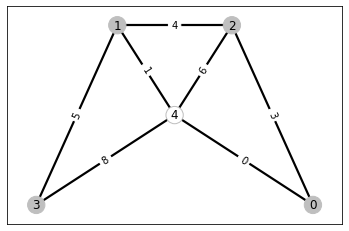

In [37]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()

In [38]:
matching_p.edges()

[(0, 4, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 4, {'fault_ids': {1}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 2, {'fault_ids': {3}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 2, {'fault_ids': {4}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 3, {'fault_ids': {5}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 4, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 4, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0})]

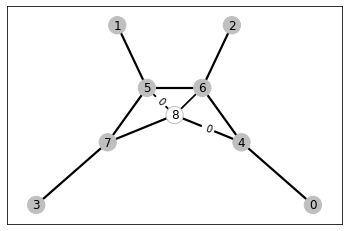

In [39]:
matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()

In [40]:
matching_my_c.edges()

[(0,
  4,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (1,
  5,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (2,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (3,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  None,
  {'fault_ids': {0}, 'weight': 2.9444389791664403, 'error_probability': 0.05}),
 (5,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  None,
  {'fault_ids': {0},
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (6,
  None,
  {'fault_ids': set(),
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (7,
  None,
  {'fa

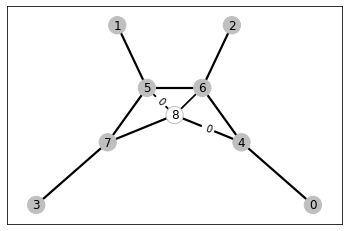

In [41]:
matching_sc = Matching.from_stim_circuit(sc_err)
matching_sc.draw()

In [42]:
matching_sc.edges()

[(0,
  4,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (1,
  5,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (2,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (3,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  None,
  {'fault_ids': {0}, 'weight': 2.9444389791664403, 'error_probability': 0.05}),
 (5,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  None,
  {'fault_ids': {0},
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (6,
  None,
  {'fault_ids': set(),
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (7,
  None,
  {'fa

In [43]:
dem = my_c.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.05) D0 D4
    error(0.05) D1 D5
    error(0.05) D2 D6
    error(0.05) D3 D7
    error(0.05) D4 D6
    error(0.05) D4 L0
    error(0.05) D5 D6
    error(0.05) D5 D7
    error(0.095) D5 L0
    error(0.095) D6
    error(0.05) D7
''')


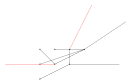

In [44]:
dem.diagram("matchgraph-svg")

In [45]:
dem_stim = sc_err.detector_error_model()
print(repr(dem_stim))

stim.DetectorErrorModel('''
    error(0.05) D0 D4
    error(0.05) D1 D5
    error(0.05) D2 D6
    error(0.05) D3 D7
    error(0.05) D4 D6
    error(0.05) D4 L0
    error(0.05) D5 D6
    error(0.05) D5 D7
    error(0.095) D5 L0
    error(0.095) D6
    error(0.05) D7
    detector(2, 0, 0) D0
    detector(2, 4, 0) D1
    detector(4, 2, 0) D2
    detector(4, 6, 0) D3
    detector(2, 0, 1) D4
    detector(2, 4, 1) D5
    detector(4, 2, 1) D6
    detector(4, 6, 1) D7
''')


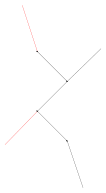

In [46]:
dem_stim.diagram("matchgraph-svg")

In [47]:
def get_num_log_errors(circuit, matching, num_shots):
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    predictions = matching.decode_batch(detection_events)
    
    
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

num_errors = get_num_log_errors(my_c, matching_my_c, num_shots)
num_errors_stim = get_num_log_errors(sc_err, matching_from_c, num_shots)
print("for my circuit", num_errors)
print("for stim built in circuit", num_errors_stim)

for my circuit 397
for stim built in circuit 344


In [51]:
def get_log_error_p(p_list, H_x,H_z, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_circuit_from_parity(H_x,H_z, p, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [63]:
p_list = np.linspace(0,0.5, 50)
d_dict = {3:[], 5:[], 7:[]}
num_shots = 100000
l = 2
type_d = {0:"X", 1:"Z"}
type=type_d[0]


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    
    d_dict[d] = get_log_error_p(p_list, H_x,H_z, num_shots)

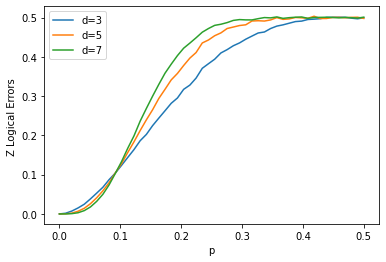

In [64]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.show()

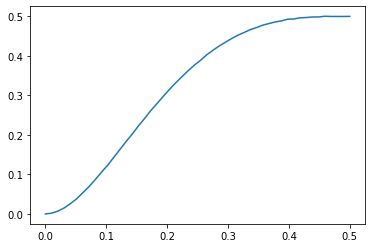

In [277]:
log_error_L = []
for p in p_list:
    sc_circuit = surface_code_circuit = stim.Circuit.generated("surface_code:rotated_memory_x",rounds=1, distance=3, before_measure_flip_probability=p)
    log_errors = get_num_log_errors(sc_circuit, matching_from_c, num_shots)
    log_error_L += [log_errors/num_shots]

plt.plot(p_list, log_error_L)
plt.show()
